# Импорт данных

Будем сравнивать различные модели для базового прогноза. 

### Для этого импортируем несколько различных показателя:
- Индекс промышленного производства
- Индекс потребительских цен
- Внешнеторговый оборот
- Инвестиции в основной капитал
- Оборот розничной торговли
- Обьем вкладов


### Также сравним качество предсказаний для:
- квартальных и ежемесячных даннных
- с сезонностью (в % к предыдущему месяцу) и без сезонности (В % к соответствующему периоду предыдущего года)

In [1]:
import numpy as np
import pandas as pd
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [2]:
date_start = date(year=2015, month=1, day=1)

def data_prerpocess(df):
    """Приводим дату к нужнмоу формату, удаляем лишние столбцы, сортируем по дате, оставим только от 2015 года"""
    
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y').dt.date
    df = df.sort_values(by='date')

    return df.drop(columns=['dataset'])\
             .sort_values(by='date', ascending=False)\
             [df.date >= date_start]

### Макроиндексы

In [3]:
path = './данные для исследований/'

In [6]:
indexes = {
    'Импорт': pd.read_csv(path + 'Внешнеторговый оборот, Россия — Диаграмма.csv', sep=';'),
    'Инвестиции в основной капитал': pd.read_csv(path + 'Инвестиции в основной капитал организаций.csv', sep=';'),
    'ИПЦ': pd.read_csv(path + 'Индекс потребительских цен, Россия — Диаграмма.csv', sep=';'),
    'ИПП': pd.read_csv(path + 'Индекс промышленного производства, Россия — Диаграмма.csv', sep=';'),
    'Оборот розничной торговли': pd.read_csv(path + 'Оборот розничной торговли, Россия — Диаграмма.csv', sep=';'),
    'Обьем вкладов': pd.read_csv(path + 'Объем вкладов (депозитов).csv', sep=';')
}

indexes = {index: data_prerpocess(df) for index, df in indexes.items()}

# Можешь эти данные на гит выложить, чтоб я мог запустить код?

# Визуализация

In [5]:
import matplotlib.pyplot as plt

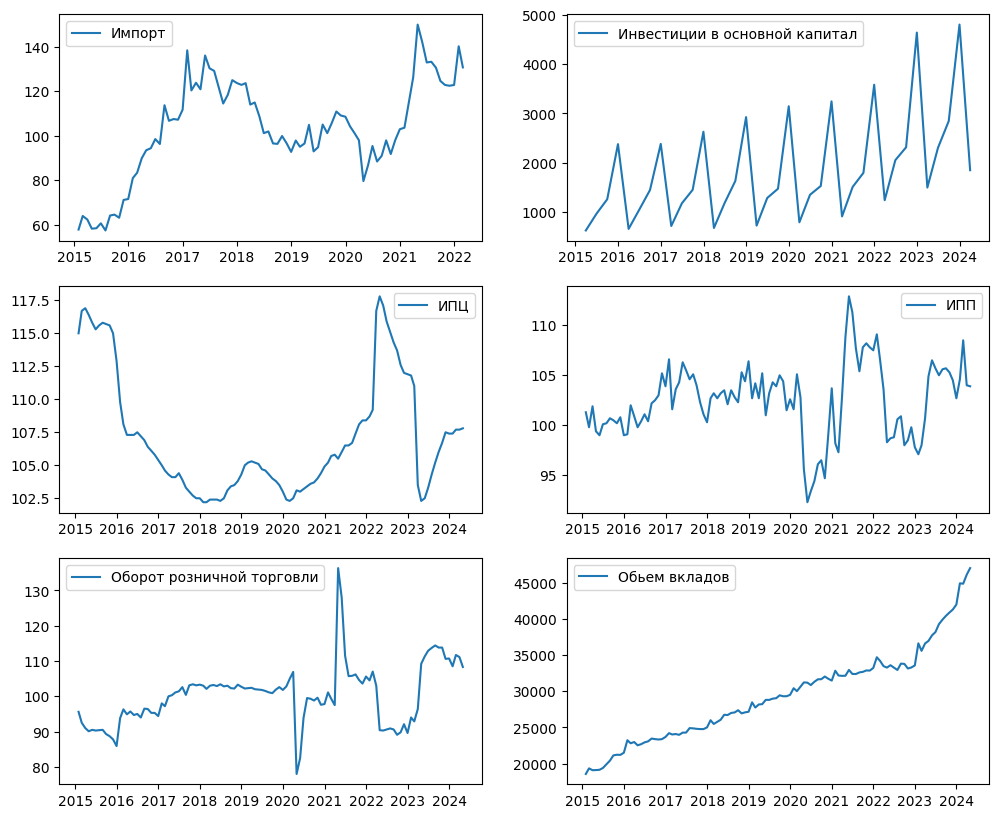

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1
                
        axes[i][j].plot(data.date, data.iloc[:, 1], label=label)
        axes[i][j].legend()


# Предобработка

Приведем среднее значения к 0 и стандартное отклонение к 1, чтобы улучшить качество нейросети

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scalers = dict()

for index, df in indexes.items():    
    goal = df.columns[-1]
    
    scalers[index] = StandardScaler().fit(df[[goal]])
    df['z_goal'] = scalers[index].transform(df[[goal]])

In [9]:
indexes['ИПЦ'].head(3)

,date,"Индекс потребительских цен, Россия: в % к предыдущему месяцу",z_goal
303,2024-04-30,107.8,0.161025
302,2024-03-31,107.7,0.138869
301,2024-02-29,107.7,0.138869


и обратно переводим

In [10]:
scalers['ИПЦ'].inverse_transform(indexes['ИПЦ'][['z_goal']])[:3]

array([[107.8],
       [107.7],
       [107.7]])

# Создание модели

- Сравним GRU и LSTM
- А также сравним итерационные модели, и модели которые сразу возвращают вектор значений

In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.layers import GRU, LSTM, BatchNormalization, Dropout, Dense, TimeDistributed

## Гиперпараметры модели

In [30]:
from dataclasses import dataclass, field

@dataclass
class ModelConfig:
    lookback         = 12   # Сколько берем данных для прогноза
    forecast_horizon = 3   # На сколько делаем прогноз
    n_layers         = 2   # Количество слоев
    units            = 4   # Количество нейронов на каждом слое
    batch_size       = 1
    epochs           = 100
    
    input_shape: tuple = (lookback, 1)
        
# предлагаю это все и выносить в гиперпараметры для пользователя + шаг градиентного спуска и выбор модели GRU или LSTM

## Создание модели

In [31]:
def get_model(lstm=True, vector=True):
    """
    - Если lstm = True, то будет создана модель архитектуры LSTM, иначе GRU
    - Если vector = True, то возвращаемым значением будет вектор длины ModelConfig.forecast_horizon, иначе 1
    """
    
    model = Sequential()
    Model = LSTM if lstm else GRU
    horizon = ModelConfig.forecast_horizon if vector else 1

    for i in range(ModelConfig.n_layers):
        return_sequences = True if i < ModelConfig.n_layers - 1 else False 
        
        model.add(Model(units=ModelConfig.units,
                        input_shape=(ModelConfig.lookback, 1),
                        return_sequences=return_sequences))
    # последний слой RNN перед Dense не должен возвращать последовательность. Это дополнительно параметров добавляет, а у нас и так гиперпараметризованная модель
    model.add(Dense(units=horizon))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['MAE', 'MAPE'])  #шаг LR тоже луше гиперпараметром делать. Стоит попробовать 0.001 для скалированных данных по умолчанию использовать.    
    
    return model

In [32]:
model = get_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 12, 4)             96        
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 144       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 15        
Total params: 255
Trainable params: 255
Non-trainable params: 0
_________________________________________________________________


In [33]:
# у нас около 100 точек в среднем доступно для макроданных, 80 - обучающая выборка, 80 - 12 (lookback) уже 68 точек длля обучения
# а параметров 255. Переобучение гарантировано.
# Попробуй в свой код встроить в качестве базовой модели самую простую, вот такую модель (всего 12 параметров):

# Кстати, эксперименты проводи всегда с зафиксированным seed, случайная инициализация может сильно влиять на результат
from tensorflow import compat
compat.v2.random.set_seed(1)
# Модель - один слой, один нейрон, нет линейного слоя на конце
model = Sequential()
model.add(LSTM(1, return_sequences=False,
                input_shape=(12, 1)))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


# Обучение моделей

In [14]:
import numpy as np
from typing import Iterable
from sklearn.model_selection import train_test_split

In [15]:
def prepare_rnn_data(data: Iterable, lookback: int, horizon: int) -> tuple[np.array, np.array]:
    """
    Создает батчи по lookback месяцев для иксов и по horizon месяца для игреков
    
    Также приводит к формату данных для RNN
    """
    
    data_range = range(lookback, len(data) - horizon + 1)
    
    x = np.array([data[i - lookback:i] for i in data_range])
    x = np.reshape(x, (x.shape[0], lookback, 1))

    y = np.array([data[i:i + horizon] for i in data_range])
    
    return x, y

# Сравнение моделей

In [16]:
models = {
    'векторные': {
        'lstm': {},
        'gru': {}
    },
    'итерационные': {
        'lstm': {},
        'gru': {}
    }
}

In [17]:
def fit_model(df, lstm=True, vector=True):
    X, y = prepare_rnn_data(df['z_goal'].values, ModelConfig.lookback, ModelConfig.forecast_horizon)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    x_val, y_val = x_test[-12:], y_test[-12:]
    
    model = get_model(lstm=lstm, vector=vector)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=ModelConfig.batch_size, epochs=ModelConfig.epochs)

    return model

In [18]:
def fit_all_models(models, lstm=True, vector=True):
    for index, df in indexes.items():
        # получение модели
        model = fit_model(df=df, lstm=lstm, vector=vector)
        
        lstm_type = 'lstm' if lstm else 'gru'
        vector_type = 'векторные' if vector else 'итерационные'
        
        # добавление модели
        models[vector_type][lstm_type][index] = model

# GRU итерационная

In [29]:
fit_all_models(models, lstm=False, vector=False)

Epoch 1/200
59/59 [==============================] - 2s 11ms/step - loss: 1.3828 - MAE: 0.8948 - MAPE: 153.5103 - val_loss: 1.1107 - val_MAE: 0.8414 - val_MAPE: 488.5579
Epoch 2/200
59/59 [==============================] - 0s 4ms/step - loss: 1.3340 - MAE: 0.8775 - MAPE: 147.5299 - val_loss: 1.0736 - val_MAE: 0.8289 - val_MAPE: 468.4519
Epoch 3/200
59/59 [==============================] - 0s 4ms/step - loss: 1.2865 - MAE: 0.8605 - MAPE: 142.1758 - val_loss: 1.0427 - val_MAE: 0.8185 - val_MAPE: 452.3804
Epoch 4/200
59/59 [==============================] - 0s 4ms/step - loss: 1.2421 - MAE: 0.8447 - MAPE: 136.9921 - val_loss: 1.0100 - val_MAE: 0.8067 - val_MAPE: 431.6710
Epoch 5/200
59/59 [==============================] - 0s 4ms/step - loss: 1.1990 - MAE: 0.8294 - MAPE: 132.7856 - val_loss: 0.9796 - val_MAE: 0.7954 - val_MAPE: 411.8172
Epoch 6/200
59/59 [==============================] - 0s 4ms/step - loss: 1.1599 - MAE: 0.8139 - MAPE: 126.7664 - val_loss: 0.9485 - val_MAE: 0.7839 - val_

In [30]:
models

{'векторные': {'lstm': {}, 'gru': {}},
 'итерационные': {'lstm': {},
  'gru': {'Импорт': <keras.src.engine.sequential.Sequential at 0x7fb5ac738690>,
   'Инвестиции в основной капитал': <keras.src.engine.sequential.Sequential at 0x7fb60fa1a850>,
   'ИПЦ': <keras.src.engine.sequential.Sequential at 0x7fb5ade89350>,
   'ИПП': <keras.src.engine.sequential.Sequential at 0x7fb58853a250>,
   'Оборот розничной торговли': <keras.src.engine.sequential.Sequential at 0x7fb58968b6d0>,
   'Обьем вкладов': <keras.src.engine.sequential.Sequential at 0x7fb5adaf4190>}}}

## Визуализация моделей

4/4 [==============================] - 0s 1ms/step


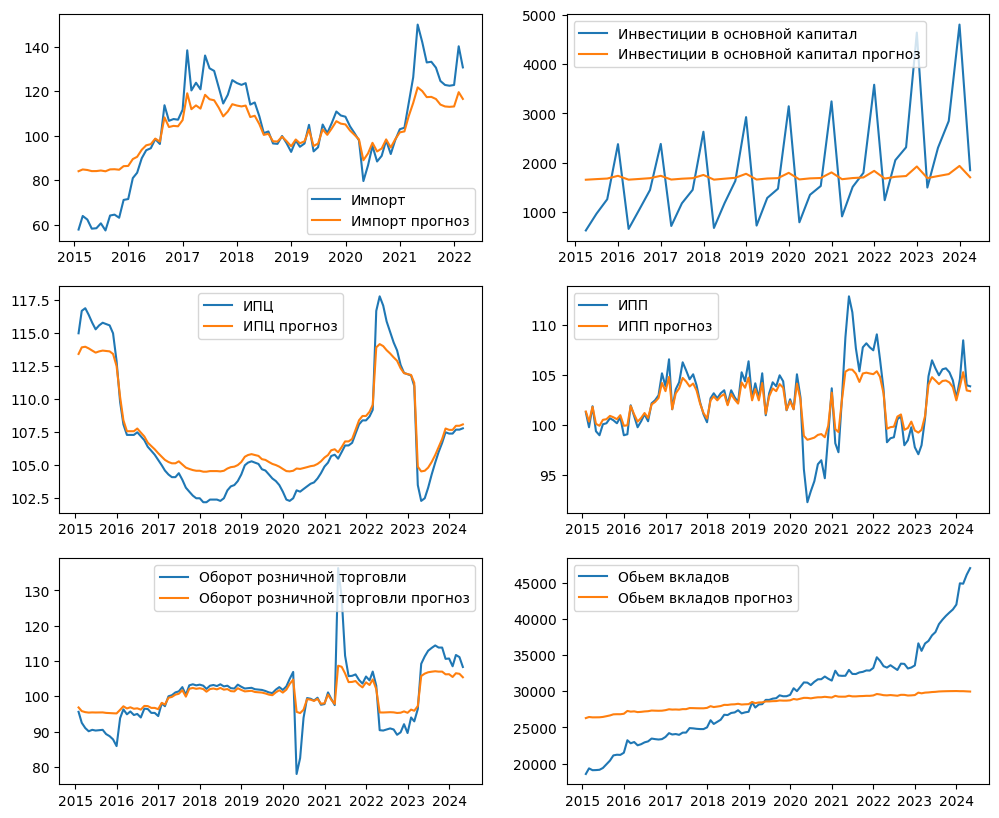

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1

        model = models['итерационные']['gru'][label]
        y_pred = scalers[label].inverse_transform(model.predict(data.iloc[:, 2]))
        
        # Хорошо бы отделить чертой, где начинается прогноз на тестовой выборке
        # При этом прогноз на тесте нужено действительно сделать итерационным: мы в периоде t, с фактом 12 лагов прогнозируем
        # на t+1; с учетом прогноза на t+1 прогнозируем на t+2 и тд. И эта логика должна быть потом в проде. Ниже примерный код.
        
        axes[i][j].plot(data.date, data.iloc[:, 1], label=label)
        axes[i][j].plot(data.date, y_pred, label=label + ' прогноз')

        axes[i][j].legend()


In [ ]:
# Пример функции для итеративного прогноза
def iterative_prediction(model, X_test, scaler, sequence_length):
    predicted_test = []
    input_seq = X_test[0]
    for i in range(len(X_test)):
        prediction = model.predict(input_seq[np.newaxis, :, :])
        predicted_test.append(prediction)
        input_seq = np.vstack([input_seq[1:], prediction])
    return np.array(predicted_test).squeeze()

# Векторная модель

In [151]:
fit_all_models(models, lstm=False, vector=True)

3
Epoch 1/100
3/3 [==============================] - 3s 241ms/step - loss: 0.8570 - MAE: 0.7117 - MAPE: 122.8315 - val_loss: 0.6447 - val_MAE: 0.6154 - val_MAPE: 107.3646
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8564 - MAE: 0.7114 - MAPE: 122.8263 - val_loss: 0.6443 - val_MAE: 0.6153 - val_MAPE: 107.2062
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8556 - MAE: 0.7111 - MAPE: 122.7613 - val_loss: 0.6440 - val_MAE: 0.6151 - val_MAPE: 107.0485
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8549 - MAE: 0.7108 - MAPE: 122.6781 - val_loss: 0.6436 - val_MAE: 0.6149 - val_MAPE: 106.8885
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8541 - MAE: 0.7105 - MAPE: 122.6768 - val_loss: 0.6432 - val_MAE: 0.6148 - val_MAPE: 106.7154
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8533 - MAE: 0.7103 - MAPE: 122.6276 - val_loss: 0.6428 - val_MAE: 0.6146 - val_MAPE

In [169]:
df = indexes['ИПП']
model = models['векторные']['gru']['ИПП']

x_train, y_train = prepare_rnn_data(df['z_goal'], lookback=12, horizon=3)

In [170]:
df.head(3)

,date,"Индекс промышленного производства, Россия: ежемесячные данные|в % к соответствующему периоду предыдущего года",z_goal
291,2024-04-30,103.9,0.397866
290,2024-03-31,104.0,0.425544
289,2024-02-29,108.5,1.671037


In [171]:
y_pred = scalers['ИПП'].inverse_transform(model.predict(x_train))

4/4 [==============================] - 0s 2ms/step


In [177]:
x_train[-1]

array([[-0.43246308],
       [-0.12800907],
       [-0.93066055],
       [-0.95833819],
       [-0.46014072],
       [-0.62620654],
       [-0.54317363],
       [-0.48781836],
       [-0.62620654],
       [-0.65388418],
       [-0.95833819],
       [-0.84762764]])

In [179]:
df

,date,"Индекс промышленного производства, Россия: ежемесячные данные|в % к соответствующему периоду предыдущего года",z_goal
291,2024-04-30,103.9,0.397866
290,2024-03-31,104.0,0.425544
289,2024-02-29,108.5,1.671037
288,2024-01-31,104.6,0.591609
287,2023-12-31,102.7,0.065734
...,...,...,...
184,2015-05-31,99.0,-0.958338
183,2015-04-30,99.4,-0.847628
182,2015-03-31,101.9,-0.155687
181,2015-02-28,99.8,-0.736917


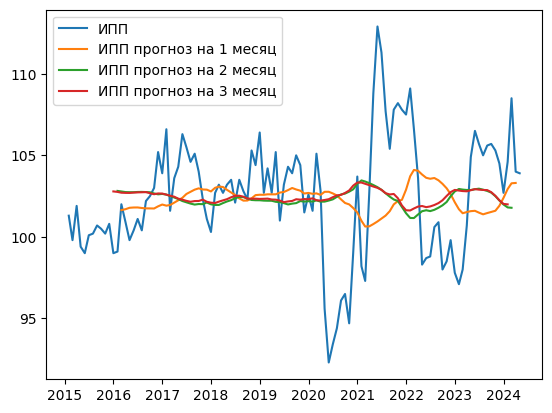

In [191]:
plt.plot(df.date, df.iloc[:, 1], label='ИПП')
plt.plot(df.date.iloc[1:-13], [el[0] for el in y_pred], label='ИПП прогноз на 1 месяц')
plt.plot(df.date.iloc[2:-12], [el[1] for el in y_pred], label='ИПП прогноз на 2 месяц')
plt.plot(df.date.iloc[3:-11], [el[2] for el in y_pred], label='ИПП прогноз на 3 месяц')

plt.legend()

# LSTM итерация

In [195]:
fit_all_models(models, lstm=True, vector=False)

1
Epoch 1/100
57/57 [==============================] - 2s 11ms/step - loss: 0.9524 - MAE: 0.7366 - MAPE: 119.0680 - val_loss: 0.6969 - val_MAE: 0.6330 - val_MAPE: 148.6808
Epoch 2/100
57/57 [==============================] - 0s 4ms/step - loss: 0.9422 - MAE: 0.7332 - MAPE: 115.4697 - val_loss: 0.6910 - val_MAE: 0.6315 - val_MAPE: 144.0087
Epoch 3/100
57/57 [==============================] - 0s 4ms/step - loss: 0.9314 - MAE: 0.7301 - MAPE: 113.2128 - val_loss: 0.6856 - val_MAE: 0.6301 - val_MAPE: 139.5988
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 0.9204 - MAE: 0.7265 - MAPE: 110.2129 - val_loss: 0.6793 - val_MAE: 0.6284 - val_MAPE: 133.8885
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 0.9097 - MAE: 0.7228 - MAPE: 107.2097 - val_loss: 0.6732 - val_MAE: 0.6268 - val_MAPE: 128.6319
Epoch 6/100
57/57 [==============================] - 0s 4ms/step - loss: 0.8986 - MAE: 0.7196 - MAPE: 106.5051 - val_loss: 0.6673 - val_MAE: 0.6252 - va

4/4 [==============================] - 0s 2ms/step


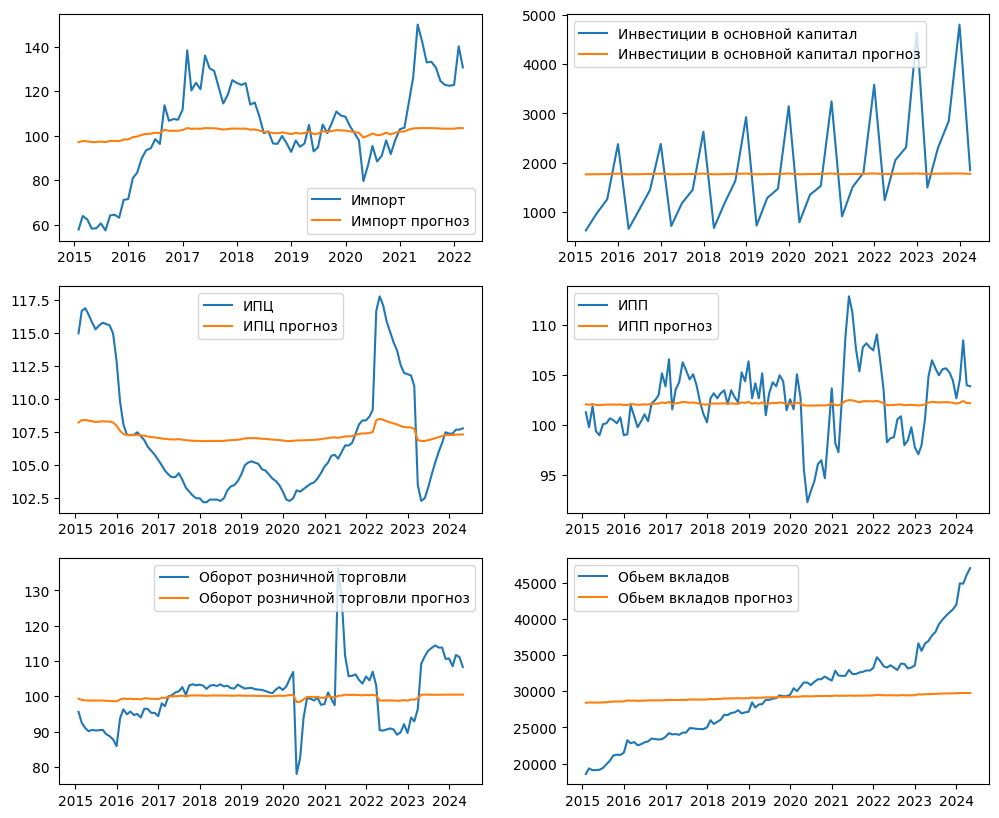

In [196]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1

        model = models['итерационные']['lstm'][label]
        y_pred = scalers[label].inverse_transform(model.predict(data.iloc[:, 2]))
        
        axes[i][j].plot(data.date, data.iloc[:, 1], label=label)
        axes[i][j].plot(data.date, y_pred, label=label + ' прогноз')

        axes[i][j].legend()
